## Tensorflow Tutorial 4: Autoencoder

Autoencoder是一個Neurel Network重要的工具，我個人認為它還漂亮的呈現Neurel Network的強大。

本單元程式碼Autoencoder部分可於[Github](https://github.com/GitYCC/Tensorflow_Tutorial/blob/master/code/04_1_Autoencoder_on_MNIST.py)下載，De-noise Autoencoder部分可於[Github](https://github.com/GitYCC/Tensorflow_Tutorial/blob/master/code/04_2_DenoiseAutoencoder_on_MNIST.py)下載。


### Autoencoder觀念解析

在「機器學習技法」的系列文章，我也[曾經介紹過Autoencoder](http://www.ycc.idv.tw/YCNote/post/35)，可以搭配這篇服用。

Autoencoder概念很簡單，就是做資訊的壓縮，概念是這樣的，當我在一層當中使用神經元愈多，可以儲存的資訊量也就愈多，相反的神經元越少，可以儲存的資訊量越少，如果我要使用Neurel Network作資料壓縮的話，我希望的是可以使用比原本更少的資訊量來儲存，如果原本是一張MNIST的圖，有28x28=784個Pixels，所以可以想知，如果我要作壓縮就要使得壓縮後的神經元可以比784個更少。

但是什麼都不做我們就可以平白無故的做到壓縮？當然不行，我們還得從資料中找到一些規律，套用這些規律把多餘的東西去除，留下精髓，我們才可以把資料作壓縮，所以在實作上我們會建立一個神經元由大到小的Neurel Network，逐步的轉換，逐步的壓縮資訊。

那麼壓縮的目的是為了什麼？當然是有辦法還原回去原本狀態，這樣的壓縮才是有意義的，例如：將文檔打包成RAR，檔案大小會變小，但如果實際要再使用這個檔案，那就必須先做解壓縮，然後還原回去原本的檔案，這裡的還原率必須是百分之一百的，Autoencoder一樣的有一個機制可以還原，在實作上我們會建立一個神經元由小到大的Neurel Network，逐步的還原回去原本的狀態。

因此一個Autoencoder的圖像就出現了，我們需要有一組「Encoder」來逐步的壓縮，最後留下非常精簡的「Embedding Code」，而這組「Embedding Code」可以再經由「Decoder」還原回去原本的樣子，那我們怎麼讓他自己產生「Encoder」和「Decoder」呢？把原本的Input當作Output的目標答案去訓練Neurel Network就可以了，這就是Autoencoder巧妙的地方。

不管是「Encoder」還是「Decoder」他們的權重是可以調整的，所以如果你將Encoder+Decoder的結構建立好並搭配Input當作Output的目標答案，它在Training的過程，Autoencoder會試著找出最好的權重來使得資訊可以盡量完整還原回去，所以Autoencoder可以自行找出了Encoder和Decoder。

Encoder的效果等同於做Dimension Reduction，Encoder轉換原本數據到一個新的空間，這個空間可以比原本Features描述的空間更能精簡的描述這群數據，而中間這層Layer的數值Embedding Code就是新空間裡頭的座標，有些時候我們會用這個新空間來判斷每筆Data之間彼此的接近程度。

![autoencoder](https://github.com/GitYCC/Tensorflow_Tutorial/blob/master/img/TensorflowTutorial.007.jpeg?raw=true)

### Autoencoder程式碼

實現Autoencoder和之前DNN並沒有太大的差異，只有兩點要特別提醒一下。

第一點，以下我會特別把`encoder`額外的在`structure`裡頭輸出出來，並且增加新的函數`encode`，讓使用者可以使用Train好的Encoder來做Encode。

第二點，以下的Regularizer不是採用單純的L2 Regularizer，我將會使用Weight-Elimination L2 Regularizer，這個Regularizer的好處是會使得權重接近Sparse，也就是說權重會留下比較多的0，這有一個好處，就是每個神經元彼此之間的依賴減少了，因為內積(評估相依性)時有0的那個維度將不會有所貢獻。

Weight-Elimination L2 Regularizer有這樣的效果原因是這樣的，L2 Regularizer在抑制W的方法是，如果$W$的分量大的話就抑制多一點，如果分量小就抑制少一點（因為$W^2$微分為一次），所以最後會留下很多不為0的微小分量，不夠Sparse，這樣的Regularization顯然不夠好，L1 Regularizer可以解決這個問題（因為在大部分位置微分為常數），但不幸的是它無法微分，沒辦法作Backpropagation，所以就有了L2 Regularizer的衍生版本，

Weight-elimination L2 regularizer: 
$$
\sum_{jk} (W_{jk} (ℓ))^2 / [1+ (W_{jk} (ℓ) )^2]
$$


這麼一來不管W大或小，它受到抑制的值大小接近的 (Weight-elimination L2 regularizer微分為 $-1$次方)，因此就可以使得部分$W$可以為$0$，達成Sparse的目的。

那為什麼我要特別在Autoencoder講究Sparse特性呢？原因是我們現在正在做的事是Dimension Reduction，做這件事就好像是替原本空間找出新的軸，而這個軸的數量比原本空間軸的數量來得小，達到Dimension Reduction的效果，所以我們會希望這個新的軸彼此間可以不要太多的依賴，什麼是不依賴呢？直角座標就是最不依賴的座標系，X軸和Y軸內積為0，這樣的軸展開的效率是最好的，所以我們希望在做Regularization的同時可以減少新軸的彼此間的依賴性。

In [0]:
import random
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.logging.set_verbosity(tf.logging.ERROR)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [0]:
class Autoencoder:

    def __init__(self, n_features, learning_rate=0.5, n_hidden=[1000, 500, 250, 2], alpha=0.0):
        self.n_features = n_features

        self.weights = None
        self.biases = None

        self.graph = tf.Graph()  # initialize new grap
        self.build(n_features, learning_rate, n_hidden, alpha)  # building graph
        self.sess = tf.Session(graph=self.graph)  # create session by the graph

    def build(self, n_features, learning_rate, n_hidden, alpha):
        with self.graph.as_default():
            ### Input
            self.train_features = tf.placeholder(tf.float32, shape=(None, n_features))
            self.train_targets = tf.placeholder(tf.float32, shape=(None, n_features))

            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.y_, self.original_loss, _ = self.structure(
                                               features=self.train_features,
                                               targets=self.train_targets,
                                               n_hidden=n_hidden)

            # regularization loss
            # weight elimination L2 regularizer
            self.regularizer = \
                tf.reduce_sum([tf.reduce_sum(
                        tf.pow(w, 2)/(1+tf.pow(w, 2))) for w in self.weights.values()]) \
                / tf.reduce_sum(
                    [tf.size(w, out_type=tf.float32) for w in self.weights.values()])

            # total loss
            self.loss = self.original_loss + alpha * self.regularizer

            # define training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)

            ### Prediction
            self.new_features = tf.placeholder(tf.float32, shape=(None, n_features))
            self.new_targets = tf.placeholder(tf.float32, shape=(None, n_features))
            self.new_y_, self.new_original_loss, self.new_encoder = self.structure(
                                                          features=self.new_features,
                                                          targets=self.new_targets,
                                                          n_hidden=n_hidden)
            self.new_loss = self.new_original_loss + alpha * self.regularizer

            ### Initialization
            self.init_op = tf.global_variables_initializer()

    def structure(self, features, targets, n_hidden):
        ### Variable
        if (not self.weights) and (not self.biases):
            self.weights = {}
            self.biases = {}

            n_encoder = [self.n_features]+n_hidden
            for i, n in enumerate(n_encoder[:-1]):
                self.weights['encode{}'.format(i+1)] = \
                    tf.Variable(tf.truncated_normal(
                        shape=(n, n_encoder[i+1]), stddev=0.1), dtype=tf.float32)
                self.biases['encode{}'.format(i+1)] = \
                    tf.Variable(tf.zeros(shape=(n_encoder[i+1])), dtype=tf.float32)

            n_decoder = list(reversed(n_hidden))+[self.n_features]
            for i, n in enumerate(n_decoder[:-1]):
                self.weights['decode{}'.format(i+1)] = \
                    tf.Variable(tf.truncated_normal(
                        shape=(n, n_decoder[i+1]), stddev=0.1), dtype=tf.float32)
                self.biases['decode{}'.format(i+1)] = \
                    tf.Variable(tf.zeros(shape=(n_decoder[i+1])), dtype=tf.float32)

        ### Structure
        activation = tf.nn.relu

        encoder = self.get_dense_layer(features,
                                       self.weights['encode1'],
                                       self.biases['encode1'],
                                       activation=activation)

        for i in range(1, len(n_hidden)-1):
            encoder = self.get_dense_layer(
                encoder,
                self.weights['encode{}'.format(i+1)],
                self.biases['encode{}'.format(i+1)],
                activation=activation,
            )

        encoder = self.get_dense_layer(
            encoder,
            self.weights['encode{}'.format(len(n_hidden))],
            self.biases['encode{}'.format(len(n_hidden))],
        )

        decoder = self.get_dense_layer(encoder,
                                       self.weights['decode1'],
                                       self.biases['decode1'],
                                       activation=activation)

        for i in range(1, len(n_hidden)-1):
            decoder = self.get_dense_layer(
                decoder,
                self.weights['decode{}'.format(i+1)],
                self.biases['decode{}'.format(i+1)],
                activation=activation,
            )

        y_ = self.get_dense_layer(
            decoder,
            self.weights['decode{}'.format(len(n_hidden))],
            self.biases['decode{}'.format(len(n_hidden))],
            activation=tf.nn.sigmoid,
        )

        loss = tf.reduce_mean(tf.pow(targets - y_, 2))

        return (y_, loss, encoder)

    def get_dense_layer(self, input_layer, weight, bias, activation=None):
        x = tf.add(tf.matmul(input_layer, weight), bias)
        if activation:
            x = activation(x)
        return x

    def fit(self, X, Y, epochs=10, validation_data=None, test_data=None, batch_size=None):
        X = self._check_array(X)
        Y = self._check_array(Y)

        N = X.shape[0]
        random.seed(9000)
        if not batch_size:
            batch_size = N

        self.sess.run(self.init_op)
        for epoch in range(epochs):
            print('Epoch %2d/%2d: ' % (epoch+1, epochs))
            start_time = time.time()

            # mini-batch gradient descent
            index = [i for i in range(N)]
            random.shuffle(index)
            while len(index) > 0:
                index_size = len(index)
                batch_index = [index.pop() for _ in range(min(batch_size, index_size))]

                feed_dict = {self.train_features: X[batch_index, :],
                             self.train_targets: Y[batch_index, :]}
                _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)

                print('[%d/%d] loss = %9.4f     ' % (N-len(index), N, loss), end='\r')

            # evaluate at the end of this epoch
            msg_valid = ''
            if validation_data is not None:
                val_loss = self.evaluate(validation_data[0], validation_data[1])
                msg_valid = ', val_loss = %9.4f' % (val_loss)

            train_loss = self.evaluate(X, Y)
            print('[%d/%d] %ds loss = %9.4f %s' % (N, N, time.time()-start_time,
                                                   train_loss, msg_valid))

        if test_data is not None:
            test_loss = self.evaluate(test_data[0], test_data[1])
            print('test_loss = %9.4f' % (test_loss))

    def encode(self, X):
        X = self._check_array(X)
        return self.sess.run(self.new_encoder, feed_dict={self.new_features: X})

    def predict(self, X):
        X = self._check_array(X)
        return self.sess.run(self.new_y_, feed_dict={self.new_features: X})

    def evaluate(self, X, Y):
        X = self._check_array(X)
        return self.sess.run(self.new_loss, feed_dict={self.new_features: X,
                                                       self.new_targets: Y})

    def _check_array(self, ndarray):
        ndarray = np.array(ndarray)
        if len(ndarray.shape) == 1:
            ndarray = np.reshape(ndarray, (1, ndarray.shape[0]))
        return ndarray

### 測試Autoencoder

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

train_data = mnist.train
valid_data = mnist.validation
test_data = mnist.test

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Epoch  1/20: 
[55000/55000] 15s loss =    0.0332 , val_loss =    0.0327
Epoch  2/20: 
[55000/55000] 14s loss =    0.0303 , val_loss =    0.0299
Epoch  3/20: 
[55000/55000] 14s loss =    0.0288 , val_loss =    0.0285
Epoch  4/20: 
[55000/55000] 14s loss =    0.0278 , val_loss =    0.0275
Epoch  5/20: 
[55000/55000] 14s loss =    0.0272 , val_loss =    0.0271
Epoch  6/20: 
[55000/55000] 14s loss =    0.0267 , val_loss =    0.0268
Epoch  7/20: 
[55000/55000] 14s loss =    0.0263 , val_loss =    0.0264
Epoch  8/20: 
[55000/55000] 14s loss =    0.0259 , val_loss =    0.0262
Epoch  9/20: 
[55000/55000] 14s loss =    0.0256 , val_loss =    0.0259
Epoch 10/20: 
[55000/55000] 14s loss =    0.0254 , val_loss =    0.0257
Epoch 11/20: 
[55000/55000] 14s loss =    0.0252 , val_loss =    0.0257
Epoch 12/20: 
[55000/55000] 14s loss =    0.0250 , val_loss =    0.0256
Epoch 13/20: 
[55000/55000] 14s loss =    0.0248 , val_loss =    0.0255
Epoch 14/20: 
[55000/55000] 14s loss =    0.0247 , val_loss =   

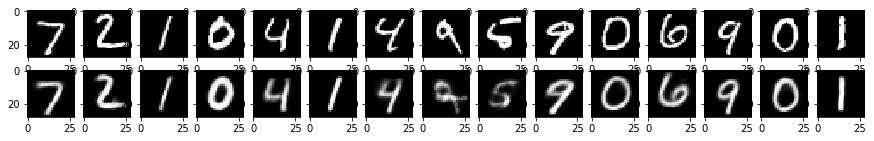

In [4]:
model_1 = Autoencoder(
    n_features=28*28,
    learning_rate= 0.0005,
    n_hidden=[512, 32, 4],
    alpha=0.0,
)
model_1.fit(
    X=train_data.images,
    Y=train_data.images,
    epochs=20,
    validation_data=(valid_data.images, valid_data.images),
    test_data=(test_data.images, test_data.images),
    batch_size = 8,
)

fig, axis = plt.subplots(2, 15, figsize=(15, 2))
for i in range(0, 15):
    img_original = np.reshape(test_data.images[i], (28, 28))
    axis[0][i].imshow(img_original, cmap='gray')
    img = np.reshape(model_1.predict(test_data.images[i]), (28, 28))
    axis[1][i].imshow(img, cmap='gray')
plt.show()

上面圖中上排是進去Autoencoder之前的圖片，下排是經過Autoencoder後的圖片，效果是不是很驚人！大致都有辦法還原回去原圖。但是仍有幾張圖還原的不是很好，做個Regularization看看能不能解決這個問題。

Epoch  1/20: 
[55000/55000] 18s loss =    0.0320 , val_loss =    0.0316
Epoch  2/20: 
[55000/55000] 17s loss =    0.0296 , val_loss =    0.0294
Epoch  3/20: 
[55000/55000] 17s loss =    0.0285 , val_loss =    0.0283
Epoch  4/20: 
[55000/55000] 17s loss =    0.0277 , val_loss =    0.0277
Epoch  5/20: 
[55000/55000] 17s loss =    0.0271 , val_loss =    0.0272
Epoch  6/20: 
[55000/55000] 17s loss =    0.0266 , val_loss =    0.0268
Epoch  7/20: 
[55000/55000] 17s loss =    0.0262 , val_loss =    0.0265
Epoch  8/20: 
[55000/55000] 17s loss =    0.0260 , val_loss =    0.0264
Epoch  9/20: 
[55000/55000] 17s loss =    0.0257 , val_loss =    0.0261
Epoch 10/20: 
[55000/55000] 17s loss =    0.0256 , val_loss =    0.0260
Epoch 11/20: 
[55000/55000] 17s loss =    0.0255 , val_loss =    0.0260
Epoch 12/20: 
[55000/55000] 17s loss =    0.0251 , val_loss =    0.0257
Epoch 13/20: 
[55000/55000] 17s loss =    0.0249 , val_loss =    0.0256
Epoch 14/20: 
[55000/55000] 17s loss =    0.0248 , val_loss =   

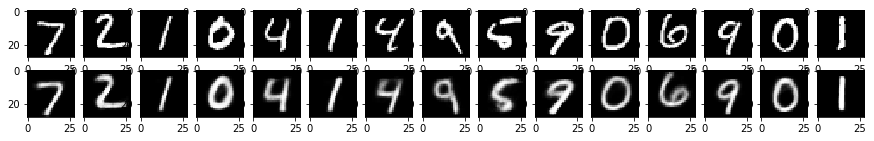

In [5]:
model_2 = Autoencoder(
    n_features=28*28,
    learning_rate= 0.0005,
    n_hidden=[512, 32, 4],
    alpha=0.001,
)
model_2.fit(
    X=train_data.images,
    Y=train_data.images,
    epochs=20,
    validation_data=(valid_data.images, valid_data.images),
    test_data=(test_data.images, test_data.images),
    batch_size = 8,
)

fig, axis = plt.subplots(2, 15, figsize=(15, 2))
for i in range(0, 15):
    img_original = np.reshape(test_data.images[i], (28, 28))
    axis[0][i].imshow(img_original, cmap='gray')
    img = np.reshape(model_2.predict(test_data.images[i]), (28, 28))
    axis[1][i].imshow(img, cmap='gray')
plt.show()

似乎看起來是有效果的，數字還原的比較清晰。

### 壓縮碼Code與視覺化

剛剛提到在Autoencoder前半段是一個Encoder，所以我們可以利用這個Encoder來做壓縮，會得到一個Code，在上面的這個例子，這個Code總共有4個值，因為中間層有4個神經元，可以把這個Code看成Dimension Reduction的結果，原本一張圖代表的是28x28=784個維度下的一個點，現在經過轉換後變成是4個維度下的一個點，而我們會直覺的認為同樣一群的數字圖形應該會有較高的相似度，所以在4個維度之下，同樣的數字圖片應該會彼此靠近的比較近，甚至聚成一團。

我想要驗證一下這件事，我們需要先圖像化，不過卻卡在維度太高的問題，人類無法想像高於3個維度以上的空間，也沒辦法將它視覺化，這個時候我們需要再做一次的Dimension Reduction，將維度降到低於3才可以視覺化，那一般手法是使用PCA來做這件事，有關於PCA我之前已經介紹過，請參考[這篇](http://www.ycc.idv.tw/YCNote/post/35)，如此一來就可以在4個維度中切一個重要的截面來視覺化這些數據。不過記得喔！4個維度才是真正可以表示這群資料，做PCA只是為了畫圖而做的粗略轉換而已。

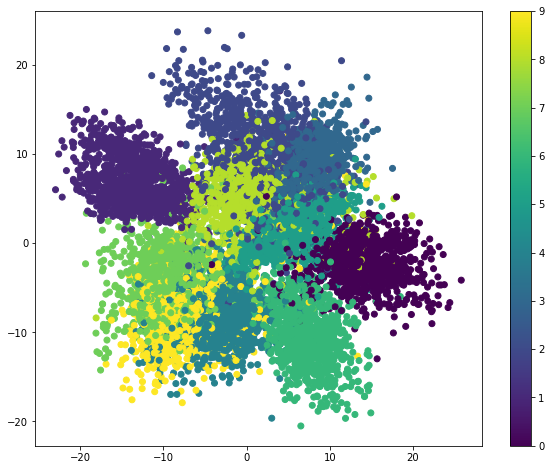

In [6]:
# get code
encode = model_2.encode(test_data.images)

# PCA 2D visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(encode)
Y = np.argmax(test_data.labels, axis=1)

# plot
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.colorbar()
plt.show()

上面我以不同顏色當作不同的數字圖形，我們可以看到同樣的數字圖形會彼此聚成一團，所以的確同樣的數字的族群會被歸類到具有相似的特性，因此在code裏頭距離是彼此靠近的，還記得一開始我們沒加Regularization時。Model會把5看成是6，在這張圖你就會到原因，因為5號藍綠色和6號黃色靠的很近，很容易誤判。

這張圖同時揭露了Autoencoder的一個強大特性，注意喔!我們一開始Train這個Autoencoder的時候是沒有給它看任何Labels的，但他卻可以在壓縮資訊的同時找出規律，這個規律可以想成是我們人類在辨認每個不同數字的方法，所以Autoencoder可以在沒有Labels的情況下做歸納和學習，因此Autoencoder常常會被用在Unsupervised Learning (非監督式學習)。

另外介紹一種也是很流行的方法叫做t-SNE (讀作"tee-snee") ，這裡不多著墨這個方法的原理，但是它卻是目前2D Visualization最流行的作法，PCA只用線性的方式去做座標轉換，也就是從一個橫切面去看數據，這樣粗略的轉換並不能讓我們在視覺化時看出資料和資料間彼此的距離，尤其是從高維度轉換過來，經常會失真，而t-SNE是針對數據和數據間的距離去做轉換，最後被攤成2維時正是顯示數據點的距離關係，更能描述群聚的現象。

來看看t-SNE做起來效果如何。

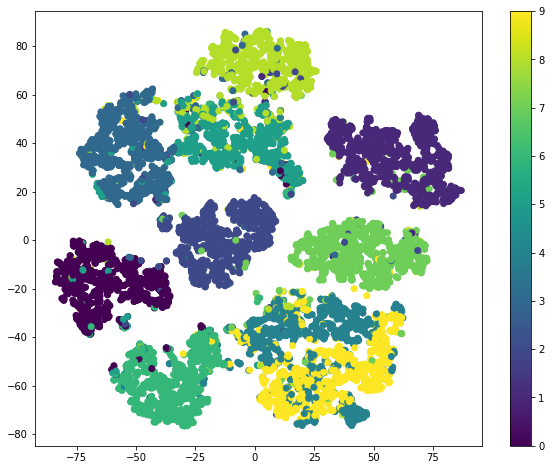

In [7]:
# get code
encode = model_2.encode(test_data.images)

# TSNE 2D visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(encode)
Y = np.argmax(test_data.labels, axis=1)

# plot
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y)
plt.colorbar()
plt.show()

### 去雜訊(De-noise) Autoencoder

我們巧妙的利用一下Autoencoder，我們將原本Autoencoder的前面加了一道人工雜訊的流程，但是最終又要讓Autoencoder試著去還原出原來沒有加入雜訊的資訊，這麼一來我們將可以找到一個Autoencoder是可以自行消除雜訊的，把這個Denoising Autoencoder加到正常Neural Network的前面，那這個Neural Network就擁有了抑制雜訊的功用，所以可以當作一種Regularization的方法。

先將圖片加上雜訊。

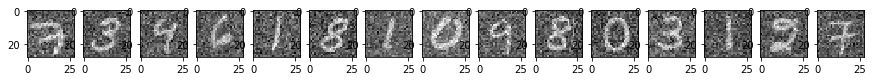

In [8]:
def add_noise(ndarr):
    noise_factor = 0.3
    noisy_ndarr = ndarr + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=ndarr.shape)
    return noisy_ndarr

noisy_train_img = add_noise(train_data.images)
noisy_valid_img = add_noise(valid_data.images)
noisy_test_img = add_noise(test_data.images)

fig, axis = plt.subplots(1, 15, figsize=(15, 1))
for i in range(0, 15):
    img = np.reshape(noisy_train_img[i], (28, 28))
    axis[i].imshow(img, cmap='gray')

plt.show()

圖片現在看起來非常的髒。

用這些髒圖片當作Input，正常圖當作Output的目標，我們就可以自然而然的Train出可以消除雜訊的Autoencoder。

Epoch  1/20: 
[55000/55000] 18s loss =    0.0393 , val_loss =    0.0389
Epoch  2/20: 
[55000/55000] 17s loss =    0.0356 , val_loss =    0.0355
Epoch  3/20: 
[55000/55000] 17s loss =    0.0341 , val_loss =    0.0341
Epoch  4/20: 
[55000/55000] 17s loss =    0.0327 , val_loss =    0.0329
Epoch  5/20: 
[55000/55000] 17s loss =    0.0320 , val_loss =    0.0324
Epoch  6/20: 
[55000/55000] 17s loss =    0.0314 , val_loss =    0.0320
Epoch  7/20: 
[55000/55000] 17s loss =    0.0309 , val_loss =    0.0316
Epoch  8/20: 
[55000/55000] 18s loss =    0.0307 , val_loss =    0.0315
Epoch  9/20: 
[55000/55000] 17s loss =    0.0302 , val_loss =    0.0312
Epoch 10/20: 
[55000/55000] 17s loss =    0.0299 , val_loss =    0.0309
Epoch 11/20: 
[55000/55000] 17s loss =    0.0298 , val_loss =    0.0310
Epoch 12/20: 
[55000/55000] 17s loss =    0.0296 , val_loss =    0.0308
Epoch 13/20: 
[55000/55000] 17s loss =    0.0293 , val_loss =    0.0307
Epoch 14/20: 
[55000/55000] 17s loss =    0.0291 , val_loss =   

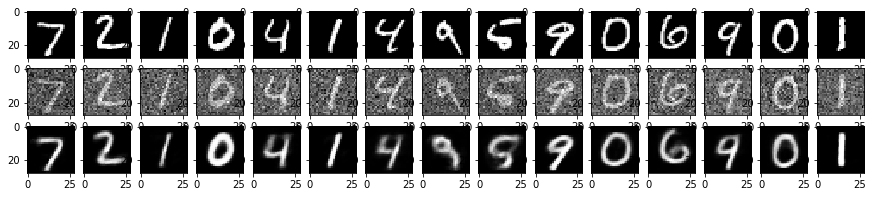

In [9]:
denoise_model = Autoencoder(
    n_features=28*28,
    learning_rate= 0.0003,
    n_hidden=[512, 32, 4],
    alpha=1.0,
)
denoise_model.fit(
    X=noisy_train_img,
    Y=train_data.images,
    epochs=20,
    validation_data=(noisy_valid_img, valid_data.images),
    test_data=(noisy_test_img, test_data.images),
    batch_size = 8,
)

fig, axis = plt.subplots(3, 15, figsize=(15, 3))
for i in range(0, 15):
    img_original = np.reshape(test_data.images[i], (28, 28))
    axis[0][i].imshow(img_original, cmap='gray')
    img_noisy = np.reshape(noisy_test_img[i], (28, 28))
    axis[1][i].imshow(img_noisy, cmap='gray')
    img = np.reshape(denoise_model.predict(noisy_test_img[i]), (28, 28))
    axis[2][i].imshow(img, cmap='gray')
plt.show()

上面圖片第一排為原圖，第二排是加完雜訊後的結果，第三排是經過Autoencoder後的圖，傑克真的是太神奇啦！所有的雜訊都被消除掉了，特別注意，這裡我的Regularization下的特別重，原因是雜訊增多了，也更容易Overfitting，所以要下更多的Regularization才能抑制它。